# **Unstructured Pruning（非構造枝刈り）・Structured Pruning（構造化枝刈り）**


AIモデルは2025年現在，高性能化が進んでいます．しかし，AIモデルの高性能化は膨大なパラメータ数に支えられています．

そのため，高性能なAIは高価な計算資源と長い推論速度を必要とします．

結果として，計算資源の限られたデバイスやリアルタイムな推論を必要とする環境では活用が困難であるという課題があります．

そこで，AIモデルの性能低下を抑制しつつ軽量化および高速化を果たす技術として**Pruning**　(枝刈り)があります．

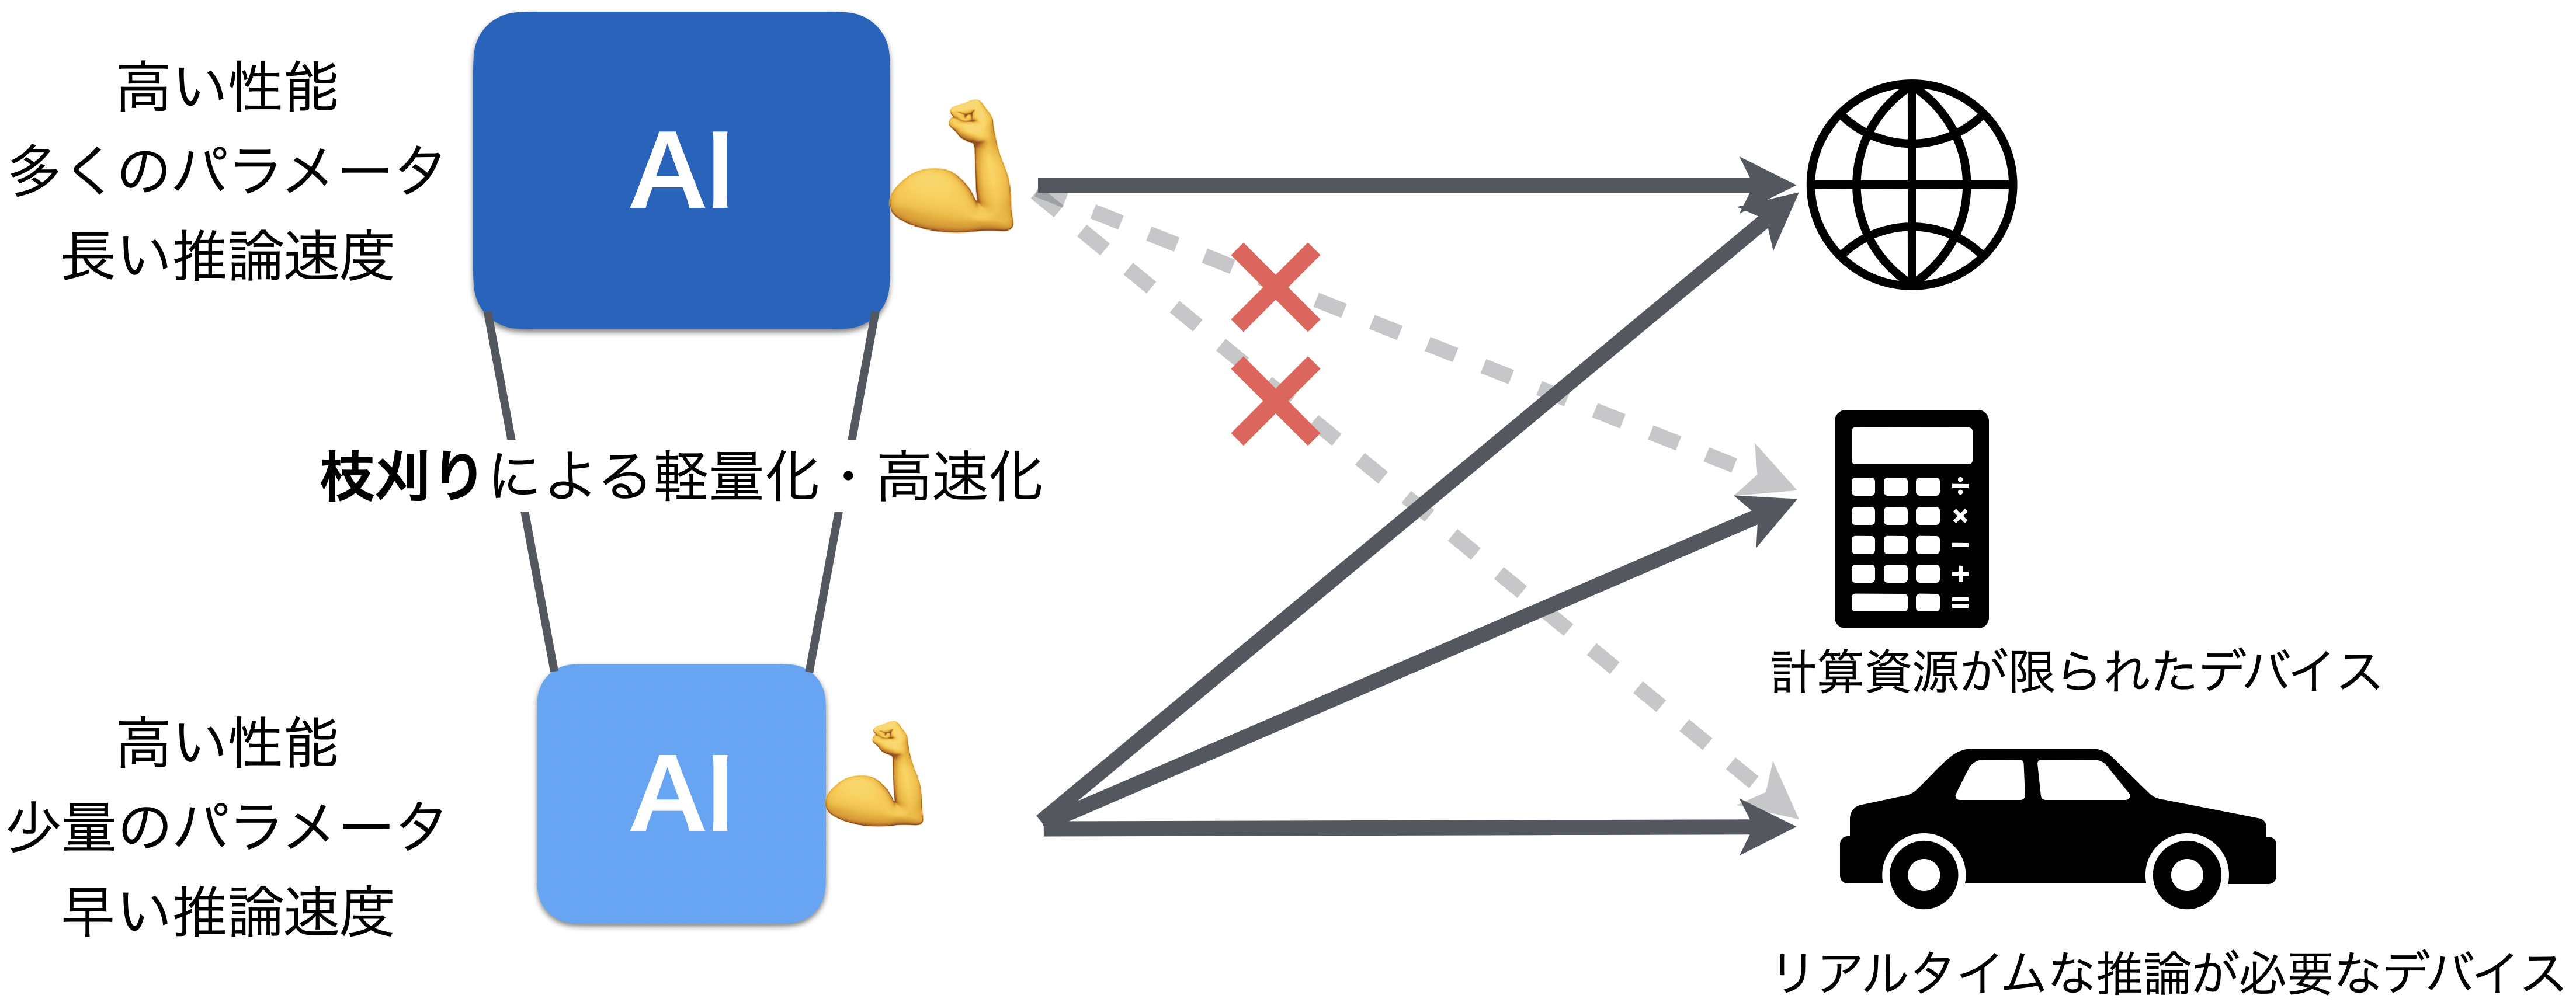

本セクションでは，前章のCNNモデルを対象に非構造化枝刈りまたは，構造化枝刈りを利用してモデル圧縮を行います．

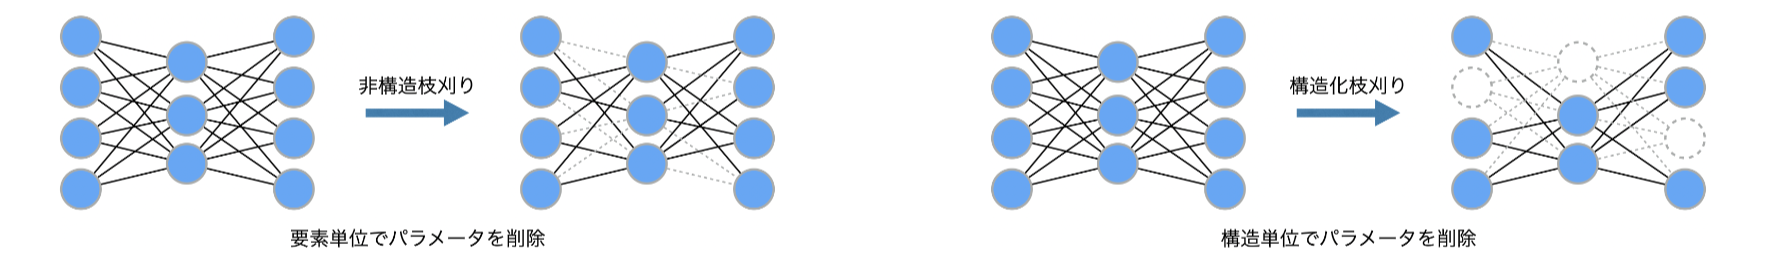

非構造化枝刈りでは線形層を対象に，重要度の低い重みを**要素単位**で削除します．
一方で構造化枝刈りでは，CNNの線形層における**ニューロン**，畳み込み層における**カーネル単位**で重要度の低いアーキテクチャを削除します．


# 準備
前回のデータセットのロードとモデル定義を参考に必要な準備を行います

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import matplotlib.pyplot as plt

from time import time
import torchvision
import torchvision.transforms as transforms

"""以下は推論速度の評価に必要なライブラリです"""
!pip install fvcore
from fvcore.nn import FlopCountAnalysis
from torch.utils.benchmark import Timer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=032b695eb27ea1d28edafc48047935a312dd21eb9125f365d80f5094ca5b5032
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=345652da73c23cf8e3ae8173d7eea00224b381864b966c0c3a48e65e860f6753
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [2]:
# エポック数の設定
NUM_EPOCH = 20

# データローダーの準備
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_data = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=False, transform=test_transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=10)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False, num_workers=10)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
#モデル構造の定義
class CNN(nn.Module):
    def __init__(self, widen_factor=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16*widen_factor, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16*widen_factor, 32*widen_factor, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8*8*32*widen_factor, 1024*widen_factor)
        self.l2 = nn.Linear(1024*widen_factor, 1024*widen_factor)
        self.l3 = nn.Linear(1024*widen_factor, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

# ベースラインの作成
枝刈りの前に，モデルを学習して性能も確認しておきます．

ここで得られたモデル性能がベースラインとなります．

In [4]:
#モデルの定義
model = CNN(widen_factor=2).cuda()
torchsummary.summary(model, (3, 32, 32))

#オプティマイザの設定
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1,NUM_EPOCH+1):
  sum_loss = 0.0
  count = 0
  for image, label in train_loader:
    image = image.cuda()
    label = label.cuda()
    y = model(image)

    #損失の計算
    loss = F.cross_entropy(y, label)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()

    pred = torch.argmax(y, dim=1)
    count += torch.sum(pred==label)
  print(f"epoch:{epoch}, mean loss:{sum_loss/len(train_loader)}, ,mean accuracy{count.item()/len(train_loader.dataset)}, elapsed_time:{time()-start}")

#ネットワークを評価モードへ変更
model.eval()

#評価の開始
count = 0
with torch.no_grad():
  for image, label in test_loader:
    image = image.cuda()
    label = label.cuda()

    y=model(image)
    pret = torch.argmax(y, dim=1)
    count += torch.sum(pret==label)
print(f"test accuracy: {count.item()/len(test_loader.dataset)}")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                 [-1, 2048]       8,390,656
              ReLU-8                 [-1, 2048]               0
            Linear-9                 [-1, 2048]       4,196,352
             ReLU-10                 [-1, 2048]               0
           Linear-11                   [-1, 10]          20,490
Total params: 12,626,890
Trainable params: 12,626,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

# 枝刈り前モデルの推論速度やパラメータ数の確認
枝刈り前のモデルの計算コスト，パラメータ数，推論時間なども確認しておきます．

今回は以下の4項目で評価します．
*   FLOPs     ：モデルが一度の推論に必要な計算回数
*   Params    ：モデルが持つパラメータ数
*   Latency   ：1つの推論に必要な時間
*   Throughput：1秒あたりの推論回数


In [5]:
#モデルの推論速度を評価
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

#1バッチ分サンプルを獲得
for images, labels in test_loader:
  x = images.to(device)
  y = labels.to(device)
  break
print(x.shape,y.shape)

#FLOPs
flops_total = FlopCountAnalysis(model,x).total()
params_total = sum(p.numel() for p in model.parameters())
bs = x.size(0)#1000
print(f"[FLOPs] per batch: {flops_total/1e9:.3f} GFLOPs, per image: {flops_total/bs/1e9:.3f} GFLOPs")
print(f"[Params] {params_total/1e6:.3f} M")

#Latency,Throughput
def infer_once():
  with torch.no_grad():
    _ = model(x)
stmt = "infer_once(); torch.cuda.synchronize()" if device.type == 'cuda' else 'infer_once()'
t = Timer(stmt=stmt, globals={"infer_once":infer_once, "torch":torch})
m = t.blocked_autorange(min_run_time=1.0)

latency_per_batch_s = m.mean
latency_per_image_s = latency_per_batch_s / bs
throughput_per_image_s = bs/latency_per_batch_s
print(f"[Latency] per batch: {latency_per_batch_s*1000:.3f} ms, per image: {latency_per_image_s*1000:.3f} ms")
print(f"[Throughput] {throughput_per_image_s:.2f} img/s (batch_size={bs})")

torch.Size([1000, 3, 32, 32]) torch.Size([1000])
[FLOPs] per batch: 18.207 GFLOPs, per image: 0.018 GFLOPs
[Params] 12.627 M
[Latency] per batch: 14.662 ms, per image: 0.015 ms
[Throughput] 68205.72 img/s (batch_size=1000)


# モデルの保存
学習済みモデルを再度呼び出せるようにモデルを保存しておきます．

例では.pklと.pthで保存していますが，どちらでも大丈夫です．

In [6]:
#モデルを保存
torch.save(model, "model.pkl")
torch.save(model, "model.pth")

# 非構造枝刈り
非構造枝刈りによるモデル圧縮は重み行列を要素単位で0に置換します．
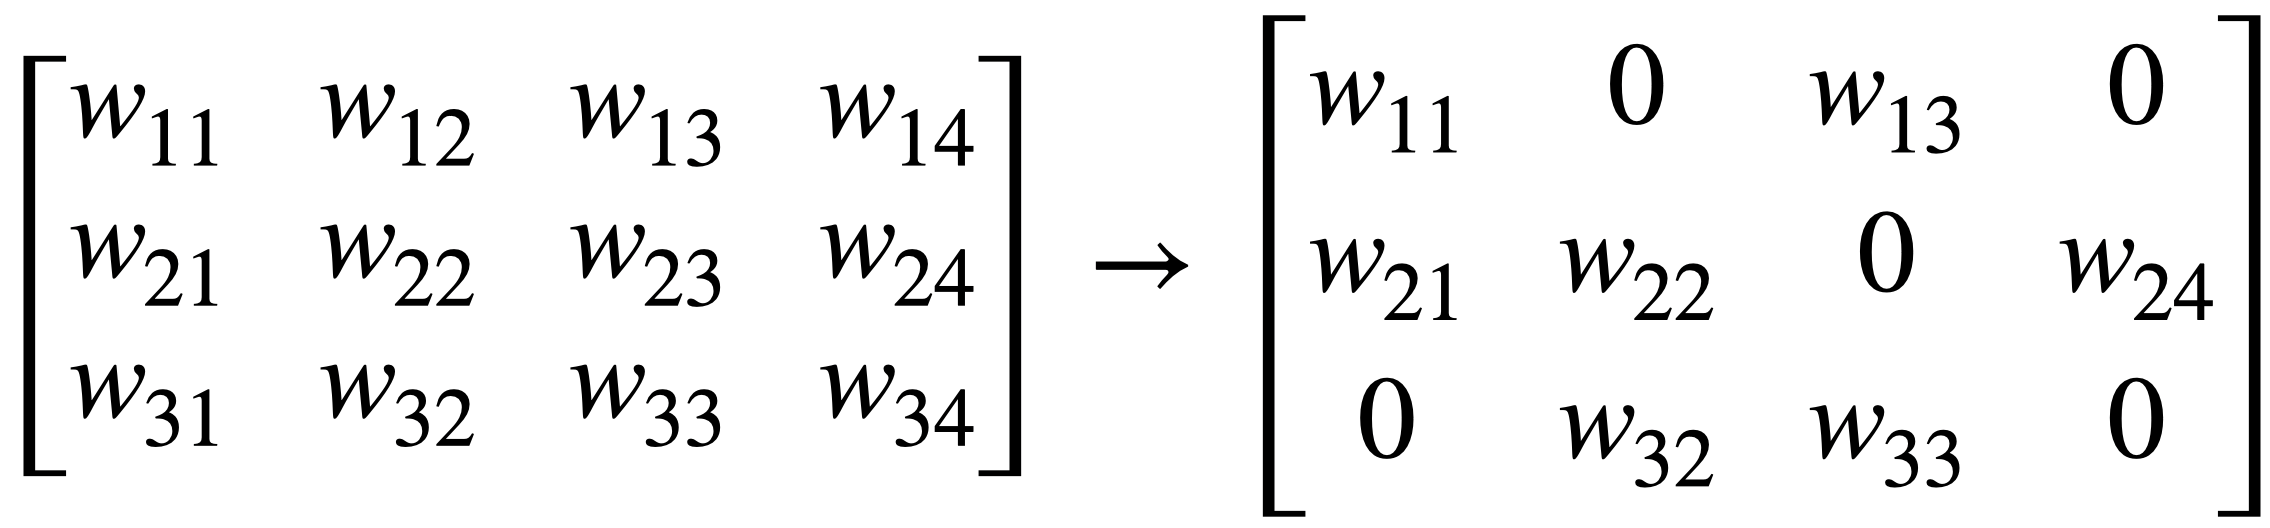
今回の例ではUnstructured_Prunerというクラスを作成します．







In [24]:
#クラスで定義する非構造化枝刈り
#構造化枝刈りのクラスを定義
class Unstructured_Pruner:
  def __init__(self, model):
    self.model=model

  def pruning(self, pruning_raitos):
    target_layer_name = []
    target_module = []
    #各層の重みを獲得
    for name, module in self.model.named_modules():
      if isinstance(module, nn.Linear):
        target_layer_name.append(name)
        target_module.append(module)
    print(f"target_layer_name: {target_layer_name}")
    print(f"target_module: {target_module}")
    weight_dict = {}
    for i, (name, layer) in enumerate(zip(target_layer_name, target_module)):
      weight_dict[name] = layer.weight.data

    #枝刈りするパラメータ数を計算
    total_params =0
    for name, weight in weight_dict.items():
      num_elements = weight.numel()
      total_params += num_elements
      print(f"{name}: {num_elements}")
    pruning_points = int(total_params*pruning_raitos)
    print(f"total_params: {total_params}")
    print(f"pruning_points: {pruning_points}")
    #枝刈りする閾値の計算
    all_weights = torch.cat([w.flatten() for w in weight_dict.values()])
    threshold = torch.kthvalue(all_weights.abs(), pruning_points).values.item()
    print(f"threshold: {threshold}")

    #閾値以下の重みを0に置換
    for name, layer in zip(target_layer_name, target_module):
      weight = layer.weight.data
      mask = weight.abs() >= threshold
      prune_weight = weight * mask
      layer.weight.data = prune_weight
      print(f"Prune_layer:{name}, pruned {(~mask).sum().item()} weights")

    return model

In [25]:
model = torch.load("model.pth",weights_only=False)#枝刈り前のモデルをロード
pruner = Unstructured_Pruner(model)
pruned_model = pruner.pruning(pruning_raitos=0.75)
torchsummary.summary(pruned_model, (3, 32, 32))


target_layer_name: ['l1', 'l2', 'l3']
target_module: [Linear(in_features=4096, out_features=2048, bias=True), Linear(in_features=2048, out_features=2048, bias=True), Linear(in_features=2048, out_features=10, bias=True)]
l1: 8388608
l2: 4194304
l3: 20480
total_params: 12603392
pruning_points: 9452544
threshold: 0.01619722694158554
Prune_layer:l1, pruned 6537730 weights
Prune_layer:l2, pruned 2909639 weights
Prune_layer:l3, pruned 5174 weights
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                 [-1,

# 非構造枝刈り後のモデル性能を評価
モデル性能はほとんど低下していません．
しかしながら，推論速度やパラメータ数はほとんど変化していません．

これはあくまでもパラメータを0に置換しただけであり，モデル構造そのものが小さくなった訳ではないことを示しています．

非構造枝刈りはモデル性能を維持しやすい反面，モデルの軽量化・高速化には専用のGPUなどが必要というデメリットが存在します．

In [26]:
#枝刈り後のネットワークを評価モードへ変更
model.eval()

#評価の開始
count = 0
with torch.no_grad():
  for image, label in test_loader:
    image = image.cuda()
    label = label.cuda()

    y=model(image)
    pret = torch.argmax(y, dim=1)
    count += torch.sum(pret==label)
print(f"test accuracy: {count.item()/len(test_loader.dataset)}")
#モデルの推論速度を評価
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

#1バッチ分サンプルを獲得
for images, labels in test_loader:
  x = images.to(device)
  y = labels.to(device)
  break
print(x.shape,y.shape)

"""推論速度の評価"""
#FLOPs
flops_total = FlopCountAnalysis(model,x).total()
params_total = sum(p.numel() for p in model.parameters())
bs = x.size(0)#1000
print(f"[FLOPs] per batch: {flops_total/1e9:.3f} GFLOPs, per image: {flops_total/bs/1e9:.3f} GFLOPs")
print(f"[Params] {params_total/1e6:.3f} M")

#Latency,Throughput
def infer_once():
  with torch.no_grad():
    _ = model(x)
stmt = "infer_once(); torch.cuda.synchronize()" if device.type == 'cuda' else 'infer_once()'
t = Timer(stmt=stmt, globals={"infer_once":infer_once, "torch":torch})
m = t.blocked_autorange(min_run_time=1.0)

latency_per_batch_s = m.mean
latency_per_image_s = latency_per_batch_s / bs
throughput_per_image_s = bs/latency_per_batch_s
print(f"[Latency] per batch: {latency_per_batch_s*1000:.3f} ms, per image: {latency_per_image_s*1000:.3f} ms")
print(f"[Throughput] {throughput_per_image_s:.2f} img/s (batch_size={bs})")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


test accuracy: 0.799


torch.Size([1000, 3, 32, 32]) torch.Size([1000])
[FLOPs] per batch: 18.207 GFLOPs, per image: 0.018 GFLOPs
[Params] 12.627 M
[Latency] per batch: 13.373 ms, per image: 0.013 ms
[Throughput] 74778.91 img/s (batch_size=1000)


# 構造化枝刈り
非構造化枝刈りのデメリットはモデル構造そのものは変わっていないことに起因しています．

そこで**構造化枝刈り**があります．

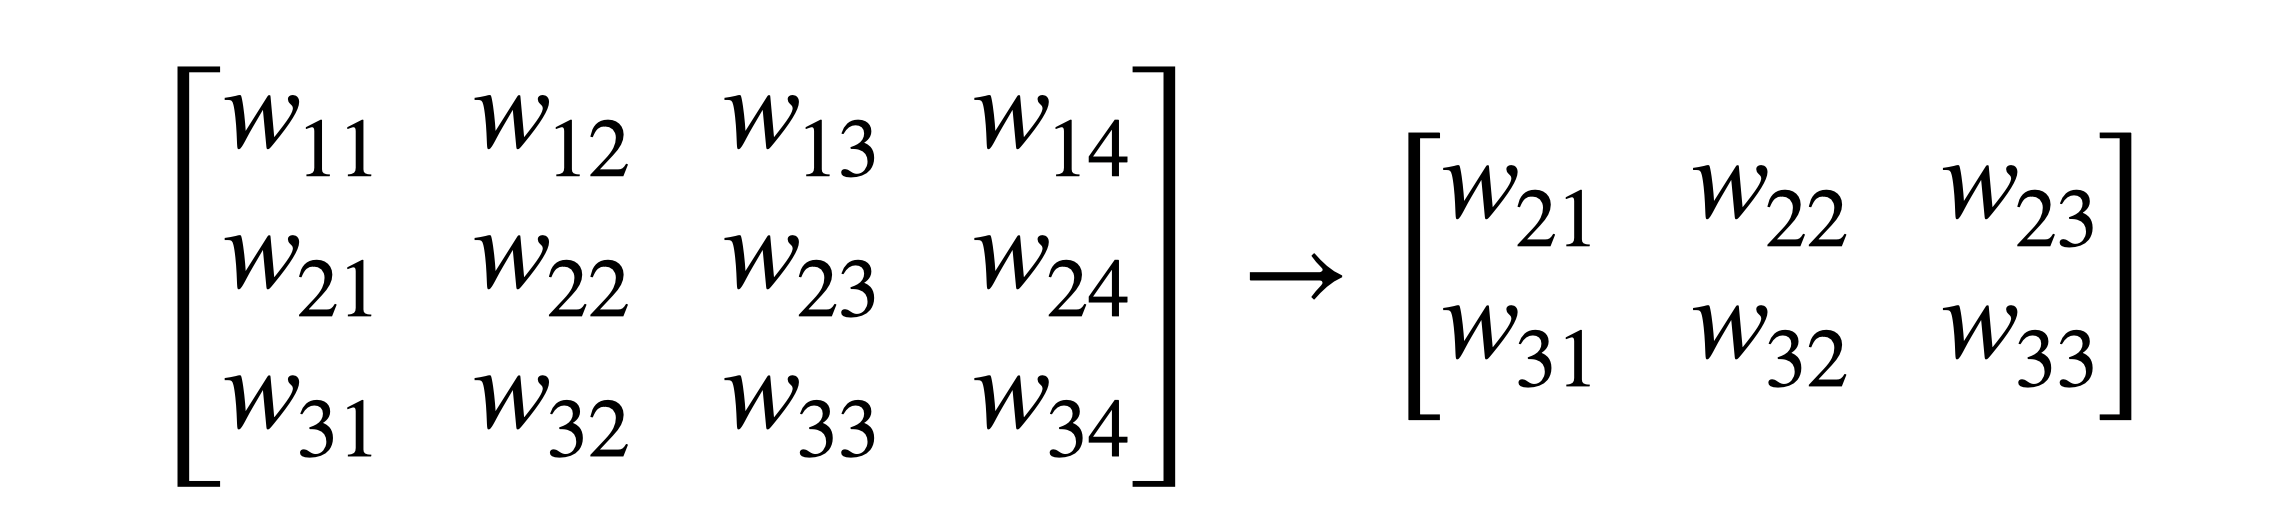

構造化枝刈りは重みを行・列単位で削除することで，モデルの構造そのものを圧縮します．これにより，モデルを軽量化お及び，高速化することができます．

※構造化枝刈りは重みの行列単位で削除するため，ニューロン単位で重要度を評価します．


In [10]:
#構造化枝刈りのクラスを定義
class Pruner:
  def __init__(self, model):
    self.model=model
    #self.score={}

  def caluculate_importance(layer,next_layer,method):
    """重要度スコアを計算する関数"""
    """
    重要度スコアはニューロンに入力する重み（layer_weight）と，
    ニューロンから出力する重みの両方で求める必要がある
    """
    #layer,next_layerの重みテンソルを獲得
    layer_weight = layer.weight.data
    next_layer_weight = next_layer.weight.data
    balance_a, balance_b = 1.0,1.0 #バランス係数
    if method=='l1':
      importance = torch.sum(torch.abs(layer_weight),dim=1)
      next_importance = torch.sum(torch.abs(next_layer_weight),dim=0)
    if method=='l2':
      importance = torch.norm(layer_weight, p=2, dim=1)
      next_importance = torch.norm(next_layer_weight, p=2, dim=0)

    importance = importance/torch.max(importance)
    next_importance = next_importance/torch.max(next_importance)
    neuron_importance = balance_a*importance + balance_b*next_importance
    print("neuron_importance shape", neuron_importance.shape)

    return neuron_importance

  def compress(model, prune_points):
    print("=== start pruning ===")
    for idx, (layer_name, neuron_idx) in enumerate(prune_points.items()):
      print(f"圧縮する層：{layer_name}，個数：{len(neuron_idx)}")
      print(f"削除するニューロン：{neuron_idx}")
      """現在の層の重みを取得し，枝刈り後の重みに変形"""
      #現在の層の重みを取得
      layer = dict(model.named_modules())[layer_name]
      current_weight = layer.weight.data
      current_bias = layer.bias.data if layer.bias is not None else None

      #新しい重みの作成
      keep_idx = [i for i in range(current_weight.size(0)) if i not in neuron_idx]
      new_weight = current_weight[keep_idx, :]
      new_bias = current_bias[keep_idx] if current_bias is not None else None
      new_out_features = len(keep_idx)
      new_in_features = current_weight.size(1)
      new_layer = nn.Linear(new_in_features,new_out_features,bias=(current_bias is not None))
      #GPUに送信
      new_layer = new_layer.to(device)
      new_layer.weight.data = new_weight
      if new_bias is not None:
        new_layer.bias.data = new_bias
      setattr(model, layer_name, new_layer)


      """次の層の入力次元を調整"""
      next_layer_name = None
      all_layers = list(model.named_modules())
      for i,(name, layer_check) in enumerate(all_layers):
        if name == layer_name:
          if i+1 < len(all_layers):
            next_layer_name = all_layers[i+1][0]
            break
      if next_layer_name and isinstance(dict(model.named_modules())[next_layer_name], nn.Linear):#next_layer_nameが線形層であれば入力サイズを調整
        next_layer = dict(model.named_modules())[next_layer_name]
        next_current_weight = next_layer.weight.data
        print("next_current_weight",next_current_weight.shape)
        new_next_current_weight = next_current_weight[:,keep_idx]
        print("new_next_current_weight",new_next_current_weight.shape)
        new_next_layer = nn.Linear(new_out_features, next_layer.out_features, bias=(next_layer.bias is not None))
        #デバイスを合わせる
        nex_next_layer = new_next_layer.to(device)

        new_next_layer.weight.data = new_next_current_weight
        if next_layer.bias is not None:
          new_next_layer.bias.data = next_layer.bias
        setattr(model, next_layer_name, new_next_layer)

    print("=== end pruning ===")
    return model

  def pruning(self, model, pruning_raitos, method):
    self.model=model

    """枝刈り対象を決定(今回はnn.Linear)"""
    target_layer_name=[]#枝刈り対象となる層の名前
    target_module=[]#枝刈り対象となる層のモジュール
    for name, module in self.model.named_modules():
      if isinstance(module, nn.Linear):
        target_layer_name.append(name)
        target_module.append(module)

    #ニューロン単位のスコアを計算
    score={}
    for i,(name,layer) in enumerate(zip(target_layer_name, target_module)):
      if i == len(target_layer_name)-1:
        print("最終層は枝刈りしない（出力するクラスの数が変わるため）")
      else:
        next_layer = target_module[i+1]
        neuron_importance = Pruner.caluculate_importance(layer=layer, next_layer=next_layer, method=method) #ニューロン単位でスコアを計算
        score[name]=neuron_importance

    #枝刈り率を計算(今回は枝刈り対象のパラメータ数を基準に枝刈り率を決定)
    num_score = torch.cat(list(score.values()))#重要度の値のみ取り出す
    num_elements = num_score.numel()#num_scoreの要素数を計算
    pruning_count = int(num_elements * pruning_raitos)
    #枝刈りする閾値を計算
    threshold = torch.kthvalue(num_score, pruning_count).values.item()

    """スコアに基づいて枝刈り箇所（pruning_points）を決定"""

    #扱いやすい形にscoreを変形
    score_dict={}
    for L_name, Imp in score.items():
      for N_idx, Score in enumerate(Imp):
        score_dict[(L_name, N_idx)]=float(Score)
    print(f"score_dict: {score_dict}")

    pruning_points = {}
    for (layer, idx), score in score_dict.items():
      if score <= threshold:
        pruning_points.setdefault(layer, []).append(idx)
    print(f"枝刈り対象数: {sum(len(idxs) for idxs in pruning_points.values())}")
    print(f"層別枝刈りインデックス: {pruning_points}")

    pruned_model = Pruner.compress(self.model, pruning_points)

    return pruned_model



枝刈り前モデルをロードし，構造化枝刈りを実行

In [11]:
model = torch.load("model.pth",weights_only=False)#枝刈り前のモデルをロード
pruner = Pruner(model)#構造化枝刈りのクラスを呼び出す
model = pruner.pruning(model=model, pruning_raitos=0.1, method="l1")#構造化枝刈りを行う(model=対象とするモデル，pruning_raitos=枝刈り率，method=重要度の評価方法)
torchsummary.summary(model, (3, 32, 32))


neuron_importance shape torch.Size([2048])
neuron_importance shape torch.Size([2048])
最終層は枝刈りしない（出力するクラスの数が変わるため）
score_dict: {('l1', 0): 1.809931755065918, ('l1', 1): 1.758689522743225, ('l1', 2): 1.7570730447769165, ('l1', 3): 1.8214510679244995, ('l1', 4): 1.7591793537139893, ('l1', 5): 1.7491168975830078, ('l1', 6): 1.7583848237991333, ('l1', 7): 1.7819180488586426, ('l1', 8): 1.7830885648727417, ('l1', 9): 1.7794196605682373, ('l1', 10): 1.7999745607376099, ('l1', 11): 1.7766307592391968, ('l1', 12): 1.766707420349121, ('l1', 13): 1.7555696964263916, ('l1', 14): 1.7983214855194092, ('l1', 15): 1.8210766315460205, ('l1', 16): 1.7819582223892212, ('l1', 17): 1.7387378215789795, ('l1', 18): 1.8173763751983643, ('l1', 19): 1.748465657234192, ('l1', 20): 1.7940884828567505, ('l1', 21): 1.7916874885559082, ('l1', 22): 1.768642544746399, ('l1', 23): 1.7448649406433105, ('l1', 24): 1.7471063137054443, ('l1', 25): 1.7523188591003418, ('l1', 26): 1.7634902000427246, ('l1', 27): 1.7656469345

# **構造化枝刈り後はファインチューニングを実行するのが一般的**
構造化枝刈りは軽量化・高速化に寄与できる一方で，非構造枝刈りと比較して，モデル性能が低下しやすいです．

そのため，構造化枝刈りごファインチューニングすることで，低下した性能を回復します．

In [19]:
#学習と評価
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#ネットワークを学習モードへ変更
model.train()
start = time()
for epoch in range(2):
  sum_loss = 0.0
  count = 0
  for image, label in train_loader:
    image = image.cuda()
    label = label.cuda()
    y = model(image)

    #損失の計算
    loss = F.cross_entropy(y, label)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()

    pred = torch.argmax(y, dim=1)
    count += torch.sum(pred==label)
  print(f"epoch:{epoch}, mean loss:{sum_loss/len(train_loader)}, ,mean accuracy{count.item()/len(train_loader.dataset)}, elapsed_time:{time()-start}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch:0, mean loss:1.0038795534454648, ,mean accuracy0.64512, elapsed_time:21.015326261520386
epoch:1, mean loss:0.8034684084108114, ,mean accuracy0.72058, elapsed_time:39.948342084884644


# 構造化枝刈り後のモデル性能を評価
パラメータ数や推論速度が変化していることが確認できます．
例ではpruning_raitoを0.5で設定したため，パラメータ数が約半分になっているはずです．

しかし，モデル性能は非構造枝刈りに比べて低下してしまっていると思われます．

構造化枝刈りは軽量化・高速化に寄与しやすい一方で，モデル性能の維持が難しいという課題があります．


In [20]:

#枝刈り後のネットワークを評価モードへ変更
model.eval()

#評価の開始
count = 0
with torch.no_grad():
  for image, label in test_loader:
    image = image.cuda()
    label = label.cuda()

    y=model(image)
    pret = torch.argmax(y, dim=1)
    count += torch.sum(pret==label)
print(count)#debug
print(f"test accuracy: {count.item()/len(test_loader.dataset)}")
#モデルの推論速度を評価
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

#1バッチ分サンプルを獲得
for images, labels in test_loader:
  x = images.to(device)
  y = labels.to(device)
  break
print(x.shape,y.shape)

#FLOPs
flops_total = FlopCountAnalysis(model,x).total()
params_total = sum(p.numel() for p in model.parameters())
bs = x.size(0)#1000
print(f"[FLOPs] per batch: {flops_total/1e9:.3f} GFLOPs, per image: {flops_total/bs/1e9:.3f} GFLOPs")
print(f"[Params] {params_total/1e6:.3f} M")

#Latency,Throughput
def infer_once():
  with torch.no_grad():
    _ = model(x)
stmt = "infer_once(); torch.cuda.synchronize()" if device.type == 'cuda' else 'infer_once()'
t = Timer(stmt=stmt, globals={"infer_once":infer_once, "torch":torch})
m = t.blocked_autorange(min_run_time=1.0)

latency_per_batch_s = m.mean
latency_per_image_s = latency_per_batch_s / bs
throughput_per_image_s = bs/latency_per_batch_s
print(f"[Latency] per batch: {latency_per_batch_s*1000:.3f} ms, per image: {latency_per_image_s*1000:.3f} ms")
print(f"[Throughput] {throughput_per_image_s:.2f} img/s (batch_size={bs})")

tensor(7456, device='cuda:0')
test accuracy: 0.7456


torch.Size([1000, 3, 32, 32]) torch.Size([1000])
[FLOPs] per batch: 9.135 GFLOPs, per image: 0.009 GFLOPs
[Params] 3.552 M
[Latency] per batch: 9.765 ms, per image: 0.010 ms
[Throughput] 102402.15 img/s (batch_size=1000)


# 畳み込み層の構造化枝刈り
構造化枝刈りはニューロン以外にも冗長なアーキテクチャを削除することができます．

今回対象とするCNNではカーネルを枝刈りします．

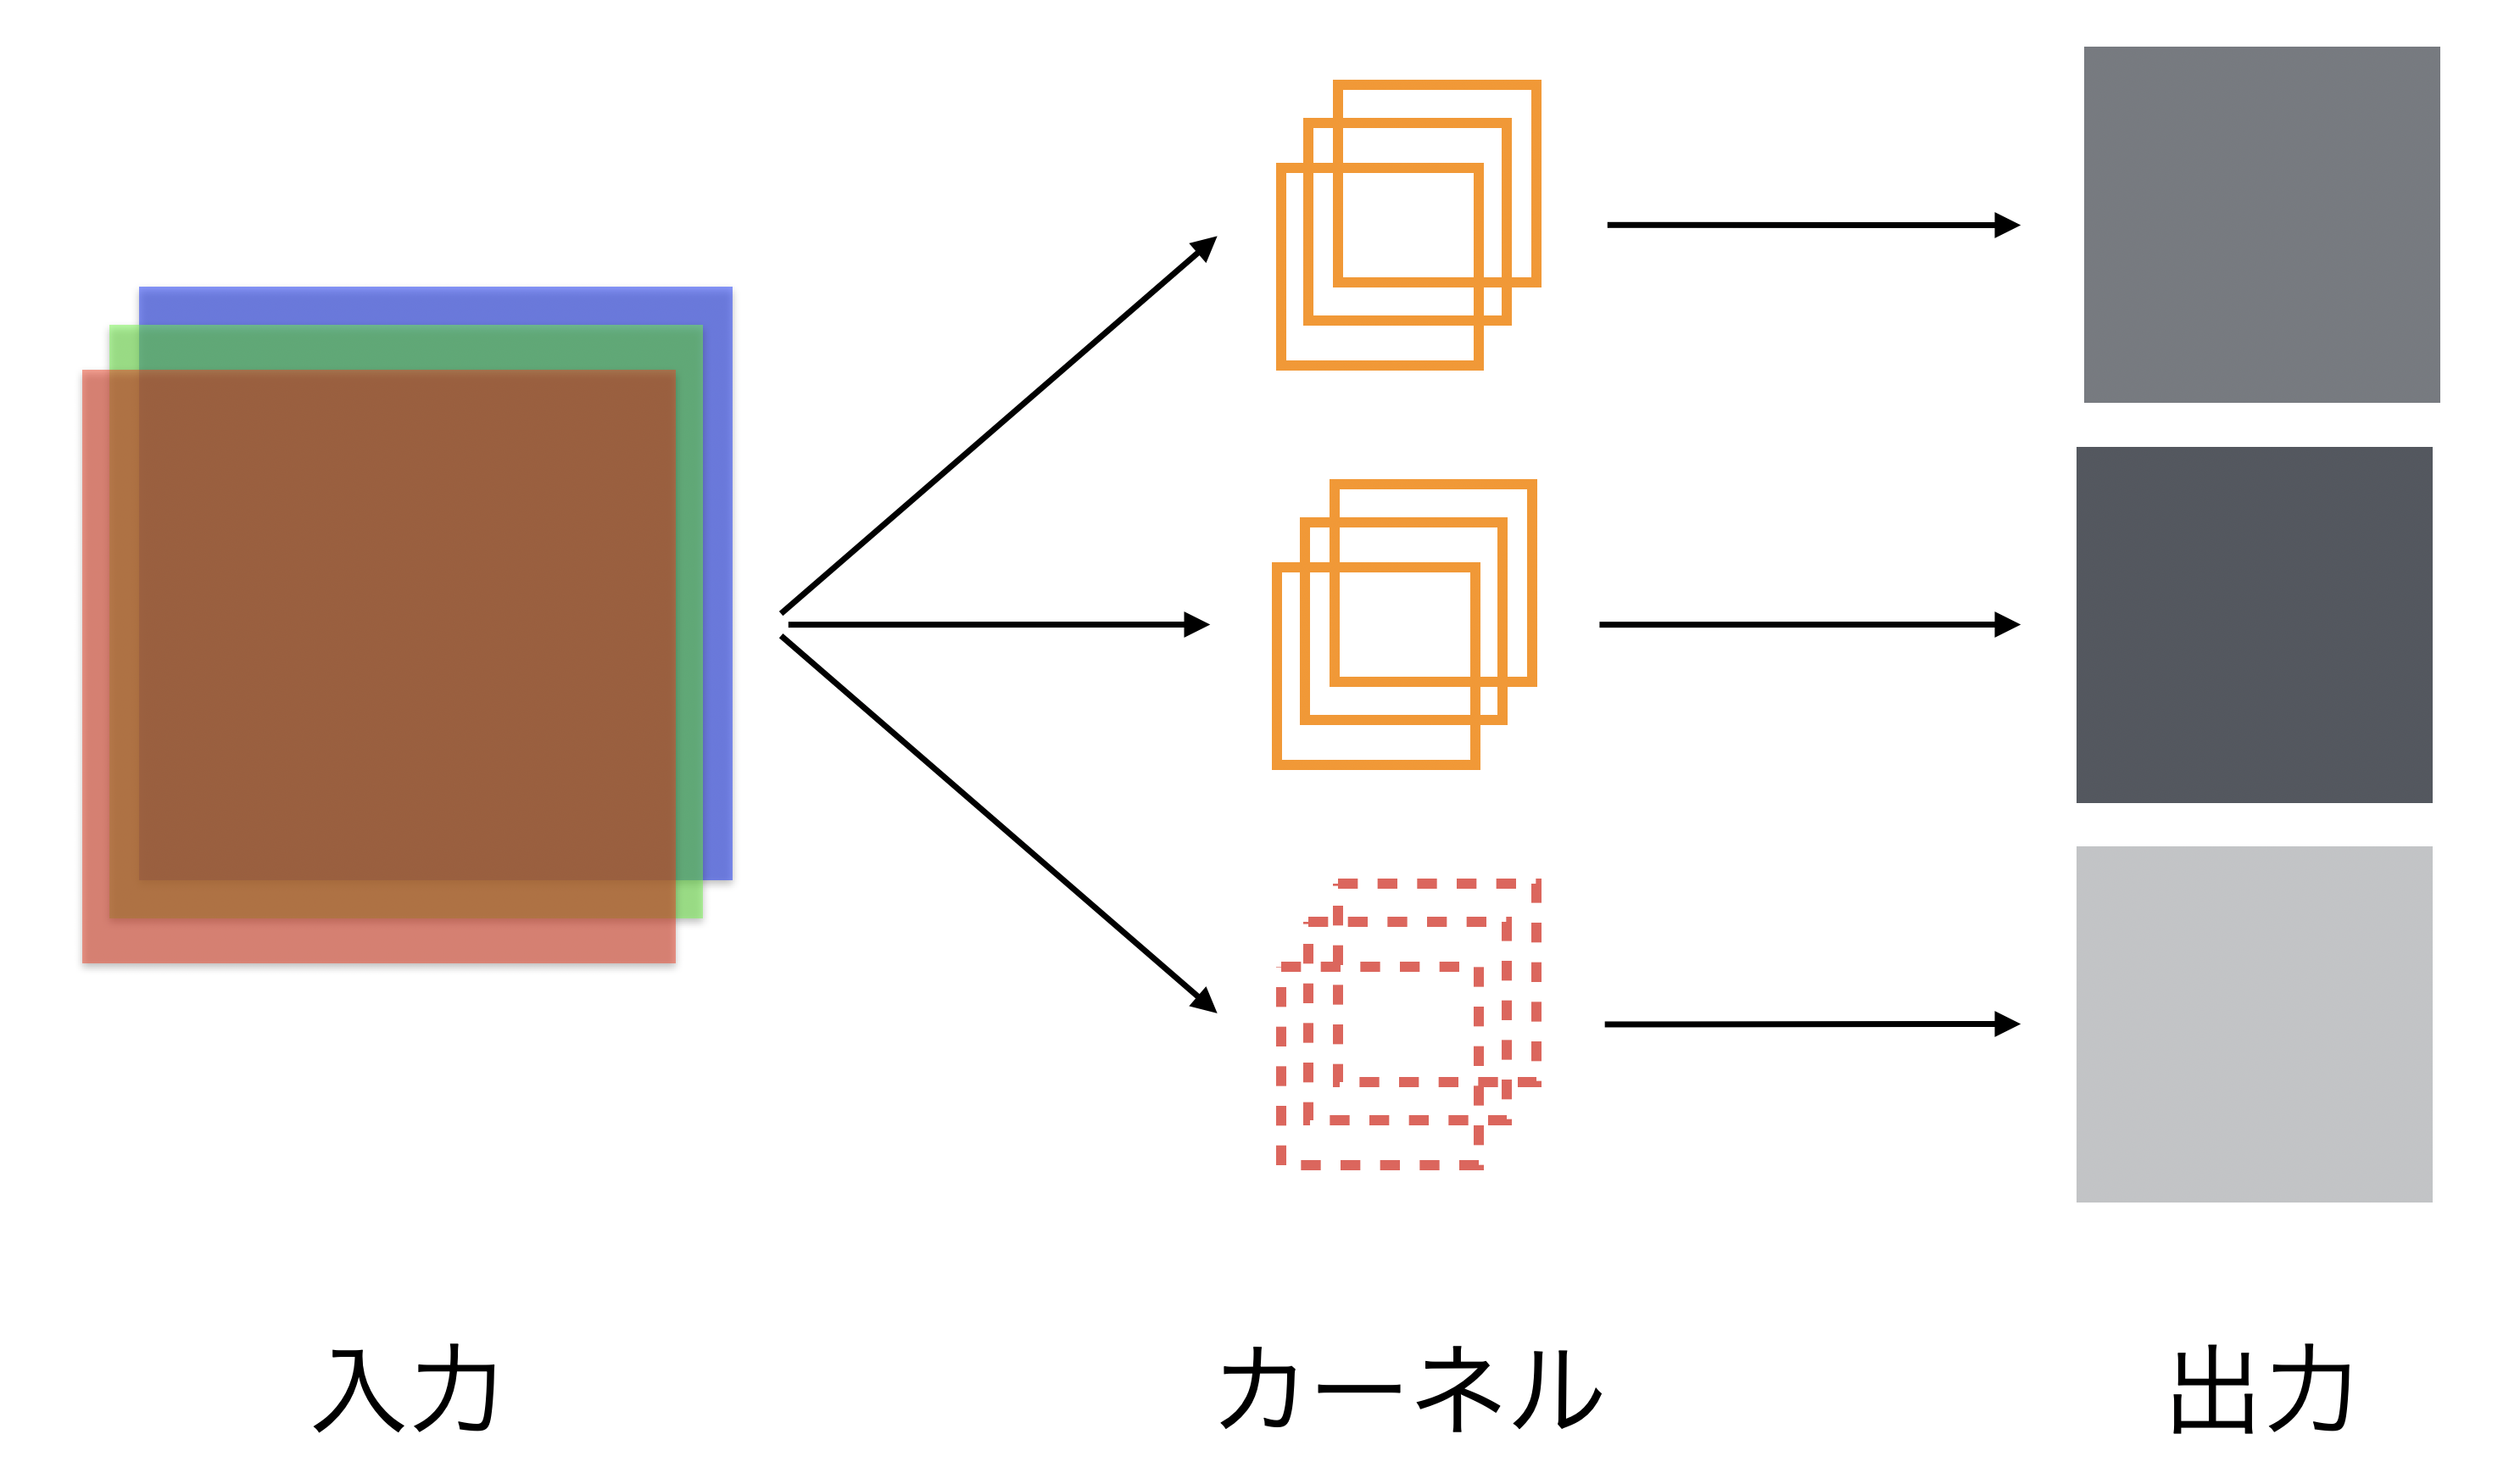

In [21]:
#畳み込み層の構造化枝刈りクラス
class CNN_Pruner:
  def __init__(self, model):
    self.model=model
    #self.kernel_score={}
  def caluculate_importance(layer):
    """重要度スコアを計算する関数"""
    kernel_weight = layer.weight.data
    kernel_importance = kernel_weight.abs().mean(dim=(1,2,3))
    print(kernel_weight.abs().mean(dim=(1,2,3)).shape)
    kernel_importance = kernel_importance/torch.max(kernel_importance)#正規化
    return kernel_importance

  def compress(model, prune_points):
    print("compress")
    for idx, (layer_name, neuron_idx) in enumerate(prune_points.items()):
      print(f"圧縮する層：{layer_name}，個数：{len(neuron_idx)}")
      print(f"削除するニューロン：{neuron_idx}")
      """現在のカーネルの次元を取得し，枝刈り後の次元に変形"""
      layer = dict(model.named_modules())[layer_name]
      current_weight = layer.weight.data
      current_bias = layer.bias.data if layer.bias is not None else None

      keep_idx = [i for i in range(current_weight.size(0)) if i not in neuron_idx]
      new_weight = current_weight[keep_idx, :]
      new_bias = current_bias[keep_idx] if current_bias is not None else None
      new_out_features = len(keep_idx)
      new_in_features = current_weight.size(1)
      new_layer = nn.Conv2d(new_in_features, new_out_features, kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding, bias=(current_bias is not None))
      #デバイスを合わせる
      new_layer = new_layer.to(device)
      new_layer.weight.data = new_weight
      if new_bias is not None:
        new_layer.bias.data = new_bias
      setattr(model, layer_name, new_layer)

      """次の層の入力次元を調整"""

      all_layers = list(model.named_modules())
      for i, (name, l) in enumerate(all_layers):
        if name == layer_name:
          if i+1 < len(all_layers):
            next_name, next_layer = all_layers[i+1]
            if isinstance(next_layer, nn.Linear):#次の層が線形層なら
              H, W = 8, 8
              keep_linear_idx = []
              for c in keep_idx:
                base = c*H*W
                keep_linear_idx.extend(range(base, base+H*W))
              keep_linear_idx = torch.tensor(keep_linear_idx, dtype=torch.long, device=next_layer.weight.device)

              new_Linear = nn.Linear(in_features=len(keep_linear_idx), out_features=next_layer.out_features, bias=(next_layer.bias is not None)).to(layer.weight.device)
              new_Linear.weight.data = next_layer.weight.data[:, keep_linear_idx]
              if next_layer.bias is not None:
                new_Linear.bias.data = next_layer.bias.data.clone()
              setattr(model, next_name, new_Linear)
              print("次の線形層を置き換えました")
            elif isinstance(next_layer, nn.Conv2d):#次の層が畳み込み層なら
              new_weight = next_layer.weight.data[:, keep_idx, :, :]
              new_next_conv = nn.Conv2d(in_channels=len(keep_idx), out_channels=next_layer.out_channels, kernel_size=next_layer.kernel_size, stride=next_layer.stride, padding=next_layer.padding, bias=(next_layer.bias is not None)).to(layer.weight.device)
              new_next_conv.weight.data = new_weight
              if next_layer.bias is not None:
                new_next_conv.bias.data = next_layer.bias.data.clone()
              setattr(model, next_name, new_next_conv)
              print("次の畳み込み層を置き換えました")


  def kernel_compress(self, model, pruning_raitos):
    self.model = model
    target_layer_name = []
    target_module = []
    for name, module in model.named_modules():
      if isinstance(module, nn.Conv2d):
        target_layer_name.append(name)
        target_module.append(module)

    #カーネル単位のスコアを計算
    score = {}
    for i,(name, layer) in enumerate(zip(target_layer_name, target_module)):
      kernel_importance = CNN_Pruner.caluculate_importance(layer)#カーネル単位でスコアを計算
      score[name] = kernel_importance

    #枝刈り率を計算(今回は枝刈り対象のパラメータ数を基準に枝刈り率を決定)
    num_score = torch.cat(list(score.values()))#重要度の値のみ取り出す
    num_elements = num_score.numel()#num_scoreの要素数を計算
    pruning_count = int(num_elements * pruning_raitos)
    #枝刈りする閾値を計算
    threshold = torch.kthvalue(num_score, pruning_count).values.item()

    #扱いやすい形にscoreを変形
    score_dict={}
    for L_name, Imp in score.items():
      for N_idx, Score in enumerate(Imp):
        score_dict[(L_name, N_idx)]=float(Score)
    print(f"score_dict: {score_dict}")

    pruning_points = {}
    for (layer, idx), score in score_dict.items():
      if score <= threshold:
        pruning_points.setdefault(layer, []).append(idx)
    print(f"枝刈り対象数: {sum(len(idxs) for idxs in pruning_points.values())}")
    print(f"層別枝刈りインデックス: {pruning_points}")

    pruned_model = CNN_Pruner.compress(model, pruning_points)






カーネル枝刈りクラスの呼び出しと，実行

In [22]:
model = torch.load("model.pth",weights_only=False)#枝刈り前のモデルをロード
pruner = CNN_Pruner(model)
purned_model = pruner.kernel_compress(model, 0.75)
torchsummary.summary(model, (3, 32, 32))

torch.Size([32])
torch.Size([64])
score_dict: {('conv1', 0): 0.5034630298614502, ('conv1', 1): 0.40306463837623596, ('conv1', 2): 0.608791708946228, ('conv1', 3): 0.5015257596969604, ('conv1', 4): 0.574428915977478, ('conv1', 5): 0.5048266053199768, ('conv1', 6): 0.49020546674728394, ('conv1', 7): 0.4479118287563324, ('conv1', 8): 0.36377301812171936, ('conv1', 9): 0.8624776005744934, ('conv1', 10): 0.4697948396205902, ('conv1', 11): 0.5184563994407654, ('conv1', 12): 0.4551805257797241, ('conv1', 13): 0.5164533257484436, ('conv1', 14): 0.33407527208328247, ('conv1', 15): 0.710168719291687, ('conv1', 16): 0.44722169637680054, ('conv1', 17): 0.38558512926101685, ('conv1', 18): 0.5826303362846375, ('conv1', 19): 0.5257633328437805, ('conv1', 20): 0.32342851161956787, ('conv1', 21): 0.7910549640655518, ('conv1', 22): 0.629177987575531, ('conv1', 23): 0.4209689795970917, ('conv1', 24): 0.7003507018089294, ('conv1', 25): 0.28989046812057495, ('conv1', 26): 0.4172966182231903, ('conv1', 27):

# カーネル枝刈り後の学習と評価

In [23]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#ネットワークを学習モードへ変更
model.train()
start = time()
for epoch in range(2):
  sum_loss = 0.0
  count = 0
  for image, label in train_loader:
    image = image.cuda()
    label = label.cuda()
    y = model(image)

    #損失の計算
    loss = F.cross_entropy(y, label)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()

    pred = torch.argmax(y, dim=1)
    count += torch.sum(pred==label)
  print(f"epoch:{epoch}, mean loss:{sum_loss/len(train_loader)}, ,mean accuracy{count.item()/len(train_loader.dataset)}, elapsed_time:{time()-start}")


#枝刈り後のネットワークを評価モードへ変更
model.eval()

#評価の開始
count = 0
with torch.no_grad():
  for image, label in test_loader:
    image = image.cuda()
    label = label.cuda()

    y=model(image)
    pret = torch.argmax(y, dim=1)
    count += torch.sum(pret==label)
print(count)#debug
print(f"test accuracy: {count.item()/len(test_loader.dataset)}")
#モデルの推論速度を評価
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

#1バッチ分サンプルを獲得
for images, labels in test_loader:
  x = images.to(device)
  y = labels.to(device)
  break
print(x.shape,y.shape)

#FLOPs
flops_total = FlopCountAnalysis(model,x).total()
params_total = sum(p.numel() for p in model.parameters())
bs = x.size(0)#1000
print(f"[FLOPs] per batch: {flops_total/1e9:.3f} GFLOPs, per image: {flops_total/bs/1e9:.3f} GFLOPs")
print(f"[Params] {params_total/1e6:.3f} M")

#Latency,Throughput
def infer_once():
  with torch.no_grad():
    _ = model(x)
stmt = "infer_once(); torch.cuda.synchronize()" if device.type == 'cuda' else 'infer_once()'
t = Timer(stmt=stmt, globals={"infer_once":infer_once, "torch":torch})
m = t.blocked_autorange(min_run_time=1.0)

latency_per_batch_s = m.mean
latency_per_image_s = latency_per_batch_s / bs
throughput_per_image_s = bs/latency_per_batch_s
print(f"[Latency] per batch: {latency_per_batch_s*1000:.3f} ms, per image: {latency_per_image_s*1000:.3f} ms")
print(f"[Throughput] {throughput_per_image_s:.2f} img/s (batch_size={bs})")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch:0, mean loss:1.715141549897011, ,mean accuracy0.37072, elapsed_time:19.978747844696045
epoch:1, mean loss:1.3860752369131883, ,mean accuracy0.50292, elapsed_time:39.66604948043823
tensor(5643, device='cuda:0')
test accuracy: 0.5643


torch.Size([1000, 3, 32, 32]) torch.Size([1000])
[FLOPs] per batch: 7.195 GFLOPs, per image: 0.007 GFLOPs
[Params] 6.972 M
[Latency] per batch: 5.130 ms, per image: 0.005 ms
[Throughput] 194927.34 img/s (batch_size=1000)


# 課題


1.   構造化枝刈りの際に使用する重要度の計算方針を変更してみましょう

2.   前章で学んだ知識蒸留を加えて，構造化枝刈り後のファインチューニングを行い，性能を評価しましょう

3.   CNNのニューロンとカーネル両方を枝刈りするコードを作成しましょう

---

ヒント

**class Pruner**では引数の**method**を変更することで異なる重要度計算を行うことができます．

**class CNN_Pruner**では **def caluculate_importance**を書き換えることで重要度の計算を変更できます．










